**I tried a classification tree and KNN, then compared them to the basic linear model. I could not get them to perform better than a basic linear model. Next, I will exand the polynomials for KNN.**

In [97]:
! git clone https://github.com/DS3001/group10/

fatal: destination path 'group10' already exists and is not an empty directory.


In [98]:
#loading packages
import pandas as pd
import numpy as np
np.random.seed(1107)

In [99]:
df_train = pd.read_csv('group10/project_2/data/training_data.csv')
df_test = pd.read_csv('group10/project_2/data/testing_data.csv')

In [100]:
# Looking at the data. I would like to transform gender, ever_married, work_type, residence_type, and smoking status
# into categorical variables

df_train.head()

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,2465,68685,Male,36.0,0,0,Yes,Govt_job,Urban,65.87,32.2,formerly smoked,0
1,4311,59058,Female,45.0,0,0,Yes,Govt_job,Rural,68.66,25.3,never smoked,0
2,2375,46068,Male,58.0,0,0,No,Self-employed,Rural,170.93,30.7,Unknown,0
3,5017,36837,Female,61.0,0,0,Yes,Self-employed,Urban,69.88,27.1,never smoked,0
4,753,30550,Female,78.0,0,0,No,Private,Urban,103.86,30.6,Unknown,0


In [101]:
#Changing ever_married to 0 (no) and 1 (yes)
df_train['ever_married'] = df_train['ever_married'].replace({"No":0, "Yes":1})
df_test['ever_married'] = df_test['ever_married'].replace({"No":0, "Yes":1})

In [102]:
# making residence type into a numerical dummy (0: Urban, 1:Rural)
df_train['Residence_type'] = df_train['Residence_type'].replace({"Urban":0, "Rural":1})
df_test['Residence_type'] = df_test['Residence_type'].replace({"Urban":0, "Rural":1})

In [103]:
#changing gender values to numbers (0:male, 1:female, 2:other)
df_train['gender'] = df_train['gender'].replace({"Male":0, "Female":1, "Other":2})
df_test['gender'] = df_test['gender'].replace({"Male":0, "Female":1, "Other":2})

In [104]:
#transforming smoking status variable to numeric (0:never, 1:formerly, 2:smokes, 3:unknown)
df_train['smoking_status'] = df_train['smoking_status'].replace({"never smoked":0, "formerly smoked":1, "smokes":2,
                                                          "Unknown":3})
df_test['smoking_status'] = df_test['smoking_status'].replace({"never smoked":0, "formerly smoked":1, "smokes":2,
                                                          "Unknown":3})

In [105]:
#transforming employment type status variable to numeric (0:Never_worked, 1:children, 2:Govt_job, 3:Private, 4:Self-employed)
df_train['work_type'] = df_train['work_type'].replace({"Never_worked":0, "children":1, "Govt_job":2,
                                                          "Private":3, "Self-employed":4})
df_test['work_type'] = df_test['work_type'].replace({"Never_worked":0, "children":1, "Govt_job":2,
                                                          "Private":3, "Self-employed":4})

In [106]:
# Splitting the data and filling in some of the NAs with averages
y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())

**The data is now clean. There are no NAs or messy variables to deal with so now my model can be pretty and hopefully more efficient.**

**I want to start with a classification decision tree**

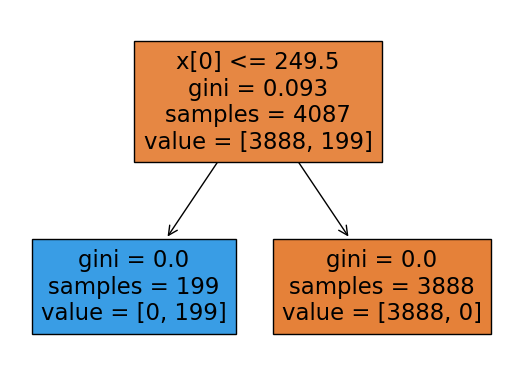

<ipython-input-107-d05952b6d17b>:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(residuals_cart)


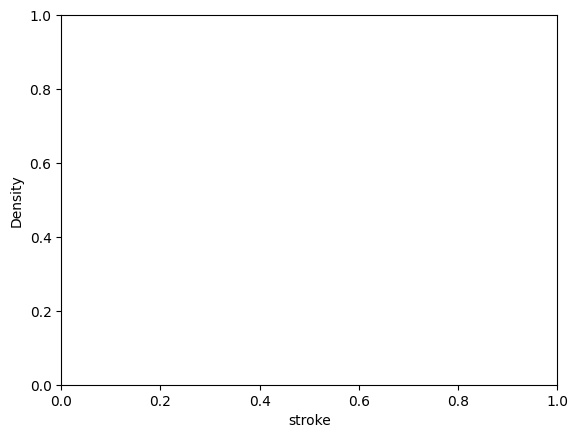

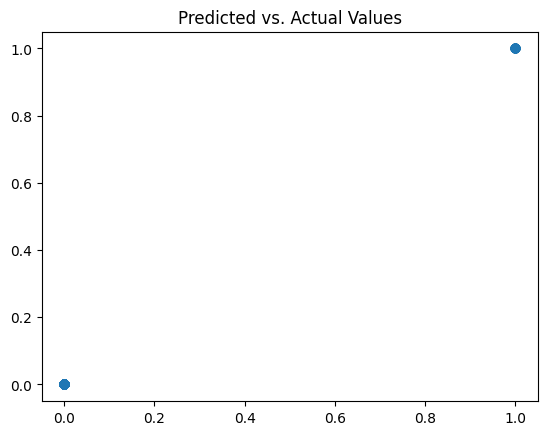

In [107]:
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

TSS = np.sum( (y_test - y_test.mean())**2 )
N_test = len(y_test)

model = tree.DecisionTreeClassifier(max_depth=5)
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart

## Residual plot:
sns.kdeplot(residuals_cart)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_cart,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()


## Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS

**So clearly, this does not look good. Time to try a new tactic. I'll do a basic linear model to see the base Rsquared, then I'll try KNN.**

In [108]:
from sklearn.linear_model import LinearRegression as lr

TSS = np.sum( (y_test - y_test.mean())**2 )
N_test = len(y_test)

#fitting model and making predictions for test data
reg = lr().fit(X_train, y_train)
y_hat = reg.predict(X_test)

#calculating r-squared
rsqu = reg.score(X_test, y_test)
print("R-Squared: ", rsqu )

#calculating RMSE
SSE_lm =np.sum((y_test-y_hat)**2)
RMSE_lm = (SSE_lm/N_test)**(1/2)
R2_lm = 1-SSE_lm/TSS
print('RMSE: ', RMSE_lm)

R-Squared:  0.1887085581105703
RMSE:  0.19420224046776433


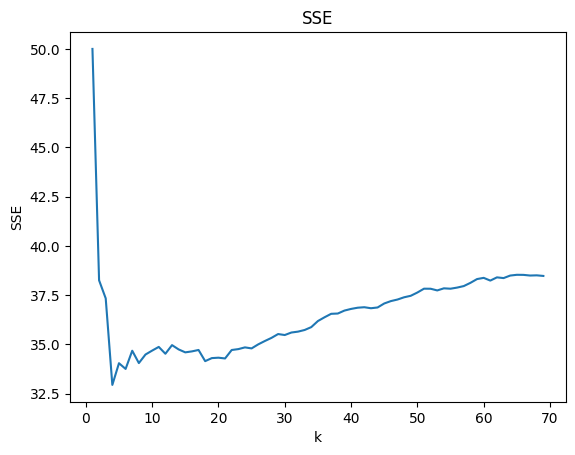

In [113]:
from sklearn.neighbors import KNeighborsRegressor

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X:
X_train_knn = X_train.apply(maxmin)
X_test_knn = X_test.apply(maxmin)

# Determine optimal k:
k_bar = 70
k_grid = np.arange(1,k_bar) # The range of k's to consider
SSE = np.zeros(k_bar-1) # For comparison purposes, store the training error
for k in range(k_bar-1):
    model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train_knn,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test_knn) # Predict values for test set
    SSE[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
SSE_min = np.min(SSE) # Lowest recorded SSE
min_index = np.where(SSE==SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index][0] # Find the optimal value of k

## SSE plot:
plt.plot(k_grid,SSE)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title('SSE')
plt.show()

## Fit optimal model:
model = KNeighborsRegressor(n_neighbors=max(3,k_star))
knn_star = model.fit(X_train_knn,y_train)
y_hat_knn = knn_star.predict(X_test_knn)
residuals_knn = y_test - y_hat_knn

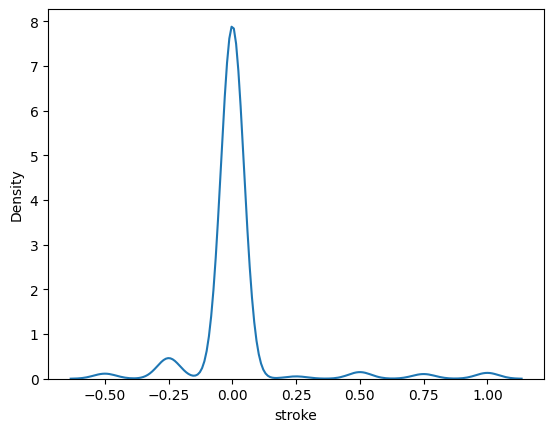

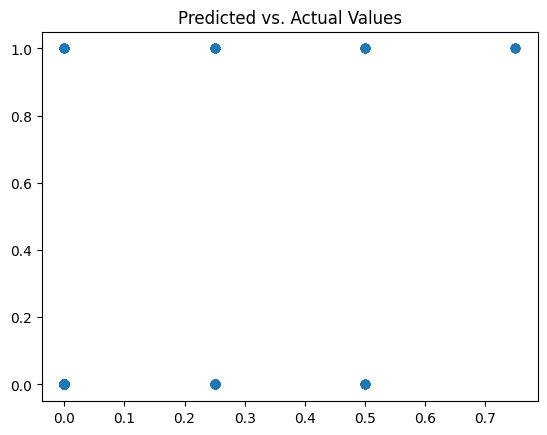

0.17943514064131835
0.3073985097636177


In [116]:
## Residual plot:
sns.kdeplot(residuals_knn)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_knn,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

## Metrics:
SSE_knn = np.sum( (y_test-y_hat_knn)**2 )
MSE_knn = SSE_knn/N_test
RMSE_knn = (SSE_knn/N_test)**(1/2)
R2_knn = 1 - SSE_knn/TSS
print(RMSE_knn)
print(R2_knn)

**KNN is not better than the basic linear model or classification decision trees.**